# Train a deep learning model with differential privacy

In [1]:
# import packages for DP
from pydiffpriv import cgfbank, dpacct

# import packages needed for deep learning
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import dpdl_utils

ctx = mx.gpu()

## Get data:  standard MNIST

In [2]:
mnist = mx.test_utils.get_mnist()
num_inputs = 784
num_outputs = 10
batch_size = 1 # this is set to get per-example gradient

In [3]:
train_data = mx.io.NDArrayIter(mnist["train_data"], mnist["train_label"],
                               batch_size, shuffle=True)
test_data = mx.io.NDArrayIter(mnist["test_data"], mnist["test_label"],
                              64, shuffle=True)
train_data2 = mx.io.NDArrayIter(mnist["train_data"], mnist["train_label"],
                               64, shuffle=True)

## Build a one hidden layer NN with Gluon

In [4]:
num_hidden = 1000
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Dense(num_hidden, in_units=num_inputs,activation="relu"))
    net.add(gluon.nn.Dense(num_outputs,in_units=num_hidden))

# get and save the parameters
params = net.collect_params()
params.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
params.setattr('grad_req', 'write')
    
# define loss function
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## Use a new optimizer called privateSGD
Basically, we add Gaussian noise to the stochastic gradient.

In [5]:
# define the update rule
def privateSGD(x, g, lr, sigma,wd=0.0,ctx=mx.cpu()):
    for (param,grad) in zip(x.values(), g):
        v=param.data()
        v[:] = v - lr * (grad +wd*v+ sigma*nd.random_normal(shape = grad.shape).as_in_context(ctx))
# Utility function to evaluate error

def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    loss_fun = .0
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data = batch.data[0].as_in_context(ctx).reshape((-1, 784))
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        loss = softmax_cross_entropy(output, label)
        loss_fun = loss_fun*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_fun

## Now let's try attaching a privacy accountant to this data set

In [6]:
# declare a moment accountant from pydiffpriv
DPobject = dpacct.anaCGFAcct()

# Specify privacy specific inputs
thresh = 4.0 # limit the norm of individual gradient
sigma = thresh

delta = 1e-5

func = lambda x: cgfbank.CGF_gaussian({'sigma': sigma/thresh}, x)


## We now specify the parameters needed for learning

In [7]:
# 
epochs = 10
learning_rate = .1

n = train_data.num_data
batchsz = 100 #

count = 0
niter=0
moving_loss = 0

grads = dpdl_utils.initialize_grad(params,ctx=ctx)

## Let's start then!

In [8]:
# declare a few place holder for logging
logs = {}
logs['eps'] = []
logs['loss'] = []
logs['MAloss'] = []
logs['train_acc'] = []
logs['test_acc'] = []

In [9]:
for e in range(epochs):
    # train_data.reset()  # Reset does not shuffle yet
    train_data = mx.io.NDArrayIter(mnist["train_data"], mnist["train_label"],
                                   batch_size, shuffle=True)
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx).reshape((-1, 784))
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()

        # calculate an moving average estimate of the loss
        count += 1
        moving_loss = .999 * moving_loss + .001 * nd.mean(loss).asscalar()
        est_loss = moving_loss / (1 - 0.999 ** count)

        # Add up the clipped individual gradient
        dpdl_utils.accumuate_grad(grads, params, thresh)

        #print(i)
        if not (i + 1) % batchsz:  # update the parameters when we collect enough data

            privateSGD(params, grads, learning_rate/batchsz,sigma,wd=0.1,ctx=ctx)

            # Keep track of the privacy loss
            DPobject.compose_subsampled_mechanism(func,1.0*batchsz/n)
  
            
            dpdl_utils.reset_grad(grads)

        if count % (10*batchsz) is 0:
            print("[%s] Loss: %s. Privacy loss: eps = %s, delta = %s " % (((count+1)/batchsz),est_loss,DPobject.get_eps(delta),delta))
            logs['MAloss'].append(est_loss)
        ##########################
        #  Keep a moving average of the losses
        ##########################

        if count % 60000 is 0:
            test_accuracy, loss_test = evaluate_accuracy(test_data, net)
            train_accuracy, loss_train = evaluate_accuracy(train_data2, net)

            print("Net: Epoch %s. Train Loss: %s, Test Loss: %s, Train_acc %s, Test_acc %s" %
                 (e, loss_train, loss_test,train_accuracy, test_accuracy))
            
            logs['eps'].append(DPobject.get_eps(delta))
            logs['loss'].append(loss_train)
            logs['train_acc'].append(train_accuracy)
            logs['test_acc'].append(test_accuracy)
            
            learning_rate = learning_rate/2
        

/usr/local/lib/python2.7/dist-packages/scipy/optimize/_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


[10] Loss: 2.06943768484. Privacy loss: eps = 0.971358107778, delta = 1e-05 
[20] Loss: 1.84368190734. Privacy loss: eps = 0.982252802702, delta = 1e-05 
[30] Loss: 1.57019112369. Privacy loss: eps = 0.993147497626, delta = 1e-05 
[40] Loss: 1.35744524226. Privacy loss: eps = 1.00404219255, delta = 1e-05 
[50] Loss: 1.15318951282. Privacy loss: eps = 1.01493688747, delta = 1e-05 
[60] Loss: 0.984449914272. Privacy loss: eps = 1.0258315824, delta = 1e-05 
[70] Loss: 0.910787531798. Privacy loss: eps = 1.03672627732, delta = 1e-05 
[80] Loss: 0.790613026683. Privacy loss: eps = 1.04762097225, delta = 1e-05 
[90] Loss: 0.729610366731. Privacy loss: eps = 1.05558451198, delta = 1e-05 
[100] Loss: 0.68380270946. Privacy loss: eps = 1.05671841883, delta = 1e-05 
[110] Loss: 0.626570992514. Privacy loss: eps = 1.05793876326, delta = 1e-05 
[120] Loss: 0.610082364481. Privacy loss: eps = 1.05928483483, delta = 1e-05 
[130] Loss: 0.591632013549. Privacy loss: eps = 1.05986112332, delta = 1e-05 

[1050] Loss: 0.37405346199. Privacy loss: eps = 1.15169470704, delta = 1e-05 
[1060] Loss: 0.379020628075. Privacy loss: eps = 1.15268339168, delta = 1e-05 
[1070] Loss: 0.481569697532. Privacy loss: eps = 1.15367207633, delta = 1e-05 
[1080] Loss: 0.414652383963. Privacy loss: eps = 1.15466076098, delta = 1e-05 
[1090] Loss: 0.421357898483. Privacy loss: eps = 1.15564944562, delta = 1e-05 
[1100] Loss: 0.443314762182. Privacy loss: eps = 1.15663813027, delta = 1e-05 
[1110] Loss: 0.396182640875. Privacy loss: eps = 1.15762681492, delta = 1e-05 
[1120] Loss: 0.36759888737. Privacy loss: eps = 1.15861549956, delta = 1e-05 
[1130] Loss: 0.424910554504. Privacy loss: eps = 1.15960418421, delta = 1e-05 
[1140] Loss: 0.423095673268. Privacy loss: eps = 1.16059286886, delta = 1e-05 
[1150] Loss: 0.442024398655. Privacy loss: eps = 1.1615815535, delta = 1e-05 
[1160] Loss: 0.436329978302. Privacy loss: eps = 1.16257023815, delta = 1e-05 
[1170] Loss: 0.36249281248. Privacy loss: eps = 1.16355

[2070] Loss: 0.424228718343. Privacy loss: eps = 1.252540541, delta = 1e-05 
[2080] Loss: 0.389119848138. Privacy loss: eps = 1.25352922564, delta = 1e-05 
[2090] Loss: 0.351585892951. Privacy loss: eps = 1.25451791029, delta = 1e-05 
[2100] Loss: 0.346605920987. Privacy loss: eps = 1.25550659494, delta = 1e-05 
[2110] Loss: 0.393413243511. Privacy loss: eps = 1.25649527958, delta = 1e-05 
[2120] Loss: 0.394907557643. Privacy loss: eps = 1.25748396423, delta = 1e-05 
[2130] Loss: 0.390599799428. Privacy loss: eps = 1.25847264888, delta = 1e-05 
[2140] Loss: 0.407522489963. Privacy loss: eps = 1.25946133352, delta = 1e-05 
[2150] Loss: 0.337147176275. Privacy loss: eps = 1.26045001817, delta = 1e-05 
[2160] Loss: 0.376419239425. Privacy loss: eps = 1.26143870282, delta = 1e-05 
[2170] Loss: 0.362870277057. Privacy loss: eps = 1.26242738746, delta = 1e-05 
[2180] Loss: 0.355825397455. Privacy loss: eps = 1.26341607211, delta = 1e-05 
[2190] Loss: 0.369064259498. Privacy loss: eps = 1.264

[3090] Loss: 0.358012833118. Privacy loss: eps = 1.35338637496, delta = 1e-05 
[3100] Loss: 0.329110279499. Privacy loss: eps = 1.3543750596, delta = 1e-05 
[3110] Loss: 0.331509713913. Privacy loss: eps = 1.35536374425, delta = 1e-05 
[3120] Loss: 0.346915179263. Privacy loss: eps = 1.3563524289, delta = 1e-05 
[3130] Loss: 0.328192356816. Privacy loss: eps = 1.35734111354, delta = 1e-05 
[3140] Loss: 0.384450558088. Privacy loss: eps = 1.35832979819, delta = 1e-05 
[3150] Loss: 0.392175222054. Privacy loss: eps = 1.35931848284, delta = 1e-05 
[3160] Loss: 0.372153162434. Privacy loss: eps = 1.36030716748, delta = 1e-05 
[3170] Loss: 0.382289697727. Privacy loss: eps = 1.36129585213, delta = 1e-05 
[3180] Loss: 0.423836290567. Privacy loss: eps = 1.36228453678, delta = 1e-05 
[3190] Loss: 0.355214057394. Privacy loss: eps = 1.36327322142, delta = 1e-05 
[3200] Loss: 0.372583125594. Privacy loss: eps = 1.36426190607, delta = 1e-05 
[3210] Loss: 0.354220493212. Privacy loss: eps = 1.365

[4120] Loss: 0.363258926838. Privacy loss: eps = 1.45522089356, delta = 1e-05 
[4130] Loss: 0.332406921289. Privacy loss: eps = 1.45620957821, delta = 1e-05 
[4140] Loss: 0.327428272996. Privacy loss: eps = 1.45719826286, delta = 1e-05 
[4150] Loss: 0.34129160146. Privacy loss: eps = 1.4581869475, delta = 1e-05 
[4160] Loss: 0.375347294563. Privacy loss: eps = 1.45917563215, delta = 1e-05 
[4170] Loss: 0.383305984371. Privacy loss: eps = 1.4601643168, delta = 1e-05 
[4180] Loss: 0.36659249567. Privacy loss: eps = 1.46115300144, delta = 1e-05 
[4190] Loss: 0.349989981714. Privacy loss: eps = 1.46214168609, delta = 1e-05 
[4200] Loss: 0.341840614378. Privacy loss: eps = 1.46313037074, delta = 1e-05 
Net: Epoch 6. Train Loss: 0.3668172636, Test Loss: 0.345251970088, Train_acc 0.904917377399, Test_acc 0.910628980892
[4210] Loss: 0.326740471362. Privacy loss: eps = 1.46411905538, delta = 1e-05 
[4220] Loss: 0.378850225781. Privacy loss: eps = 1.46510774003, delta = 1e-05 
[4230] Loss: 0.392

[5130] Loss: 0.337282706653. Privacy loss: eps = 1.55507804288, delta = 1e-05 
[5140] Loss: 0.349742157456. Privacy loss: eps = 1.55606672752, delta = 1e-05 
[5150] Loss: 0.357104731334. Privacy loss: eps = 1.55705541217, delta = 1e-05 
[5160] Loss: 0.356343934101. Privacy loss: eps = 1.55804409682, delta = 1e-05 
[5170] Loss: 0.369056621237. Privacy loss: eps = 1.55903278146, delta = 1e-05 
[5180] Loss: 0.306943625618. Privacy loss: eps = 1.56002146611, delta = 1e-05 
[5190] Loss: 0.328274388393. Privacy loss: eps = 1.56101015076, delta = 1e-05 
[5200] Loss: 0.34766876036. Privacy loss: eps = 1.5619988354, delta = 1e-05 
[5210] Loss: 0.31121254543. Privacy loss: eps = 1.56298752005, delta = 1e-05 
[5220] Loss: 0.346063648681. Privacy loss: eps = 1.5639762047, delta = 1e-05 
[5230] Loss: 0.35203270802. Privacy loss: eps = 1.56496488934, delta = 1e-05 
[5240] Loss: 0.343166467782. Privacy loss: eps = 1.56595357399, delta = 1e-05 
[5250] Loss: 0.408203401002. Privacy loss: eps = 1.566942

In [10]:
## Plot some figures!

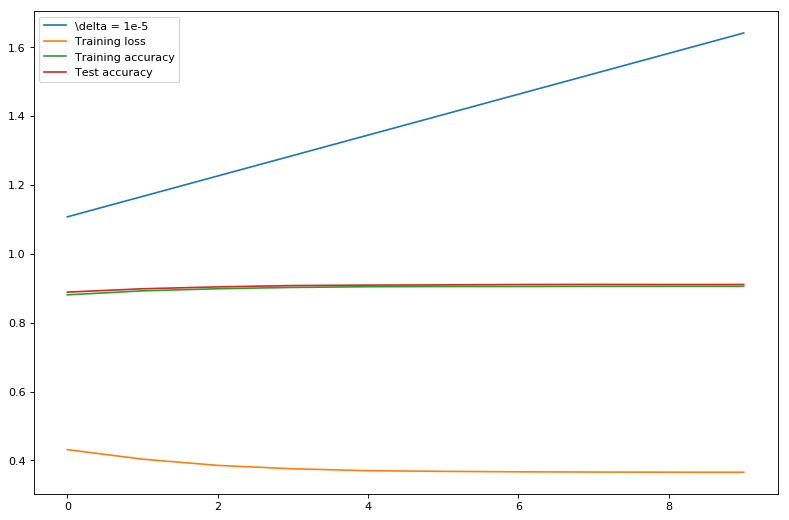

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(num=1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(epochs), logs['eps'])
plt.plot(range(epochs), logs['loss'])
plt.plot(range(epochs), logs['train_acc'])
plt.plot(range(epochs), logs['test_acc'])

plt.legend(['\delta = 1e-5', 'Training loss', 'Training accuracy','Test accuracy'], loc='best')
plt.show()